
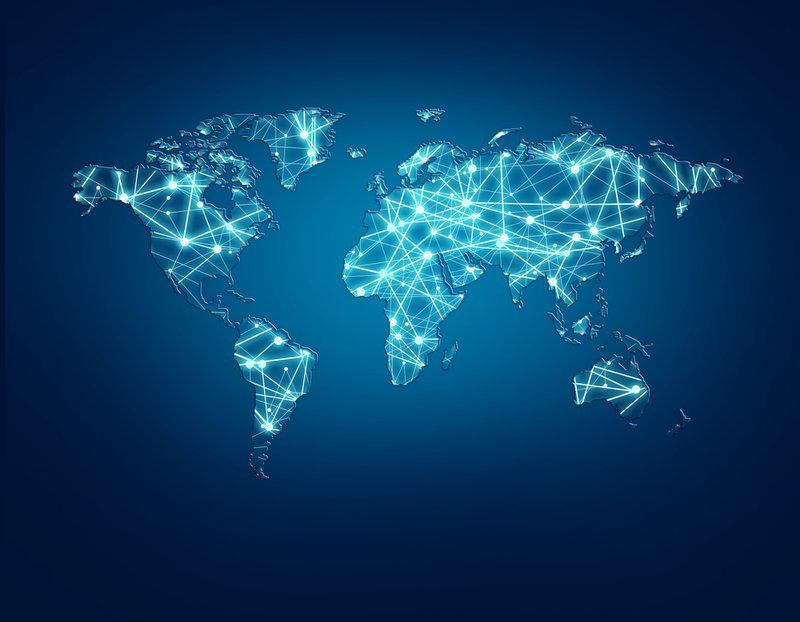


# Mental Health Acquisition 

**Author:** Carlos McCrum
***

## Overview

The goal is to find contributing factors to mental health worldwide and make predictions on these features to see where the World Health Organization can divert resources to assist in the mental health of people worldwide. This project will primarily be focusing on North and South America as there are many countries with the contributing factors varying in complexity across different cultures so utilizing a more focused approach will produce more accurate results to the countries in question. The data comes from multiple sources.  Methods include combining datasets, preprocessing, testing significant features and predictive modeling. Results show some the significant features that affect suicide rates are multilateral debt, access to clean water and electricity, education and freedom to make life choices. Recommendations would vary from country to country but overall recommendation is Universal Mental Health care, better adequacy of social safety net programs to those experiencing hardship. 


## Business Problem


Finding the contributing factors to suicide rates by country using, happiness scores, world development indicators and suicide rates from three different datasets. There is a vast amount of data contained in these datasets so the challenge is going to be narrowing down which features to work with. We can then use these feature to build a predictive model to tell us what direction a country is heading in terms fo mental health. This would be really useful to the World Health Organization as they could use these models to facilitate help to those in need in different countries. 


***

## Data Understanding

Multiple sources of data, the first being from the World Bank containing over a thousand indicators of economic development worldwide. The second comes from the Gallup World Poll containing the World Happiness Report and is a survey of the state of global happiness. The last is a dataset contains the suicide rates by country referenced from United Nations Development Program, World Health Organization, and the World Bank. The two target variables are 'Life Ladder' (happiness score) from the World Happiness Report and 'suicides/100k pop' from the Suicide Rates dataset. The world development dataset is only being used as a reference to find contributing features to either suicide rates or happiness scores and contains over a thousand indicators by year. 

***

* Import packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from statistics import mean
import numpy as np
from datetime import datetime
from time import time
from datetime import timedelta
from tqdm import tqdm 
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, KFold, GridSearchCV, cross_validate, cross_val_score, cross_val_predict
from sklearn.svm import SVR
from statsmodels.formula.api import ols
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, plot, iplot
import Code.Preparation as prep
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import precision_score, accuracy_score, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings('ignore')

Load datasets

In [2]:
#Load data and drop unecessary columns
RateDf = pd.read_csv(prep.path('sucide.csv'))
RateDf = RateDf.rename(columns={'country': 'Country'}).drop(columns='HDI for year')

HappyDf = pd.read_csv('Data/CleanedHappy.csv')
HappyDf.drop(columns='Unnamed: 0', inplace=True)

WorldDf = pd.read_csv('Data/WorldDf.csv')
WorldDf.drop(columns='Unnamed: 0', inplace=True)

### Worldwide EDA

First take a look at the world and preview our data and suicide rates by country. 

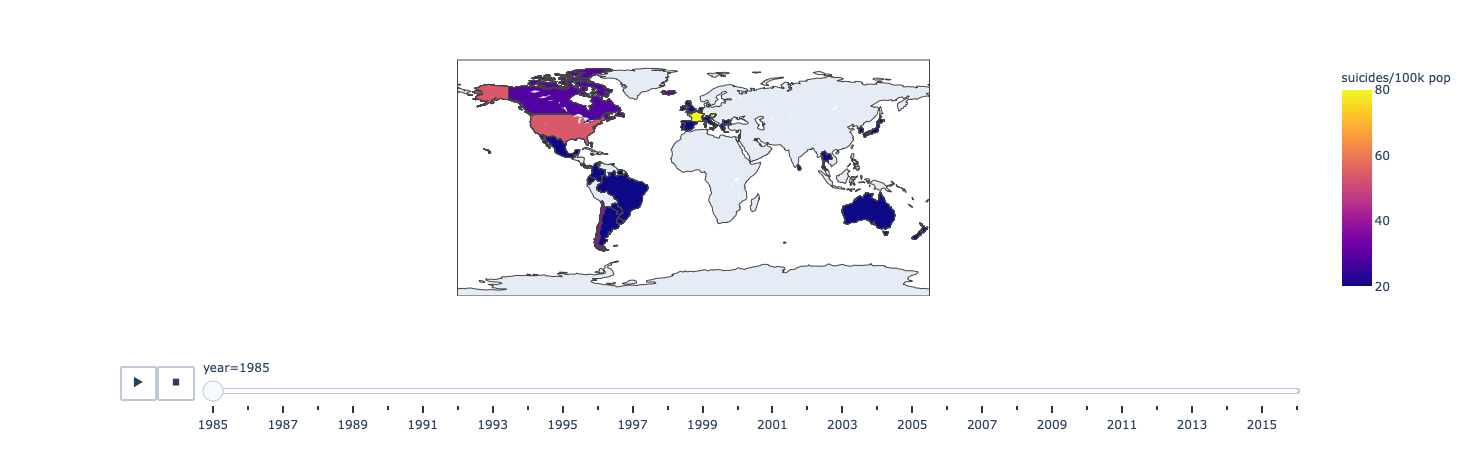

In [396]:
import plotly.express as px

plt.rcParams['figure.figsize'] = (18, 8)
plt.style.use('ggplot')
fig = px.choropleth(RateDf.sort_values(by='year'),
                    locations="Country",
                    locationmode = 'country names',
                    color="suicides/100k pop", 
                    hover_name="Country",
                    animation_frame="year", 
                    range_color=[20,80],
                    )
fig.show()

At first glance we can see that we are missing data for most of Africa and some from east Asia with brighter colors showing higher rates. Now let’s take a look at our happiness data set and preview happiness scores around the world. 

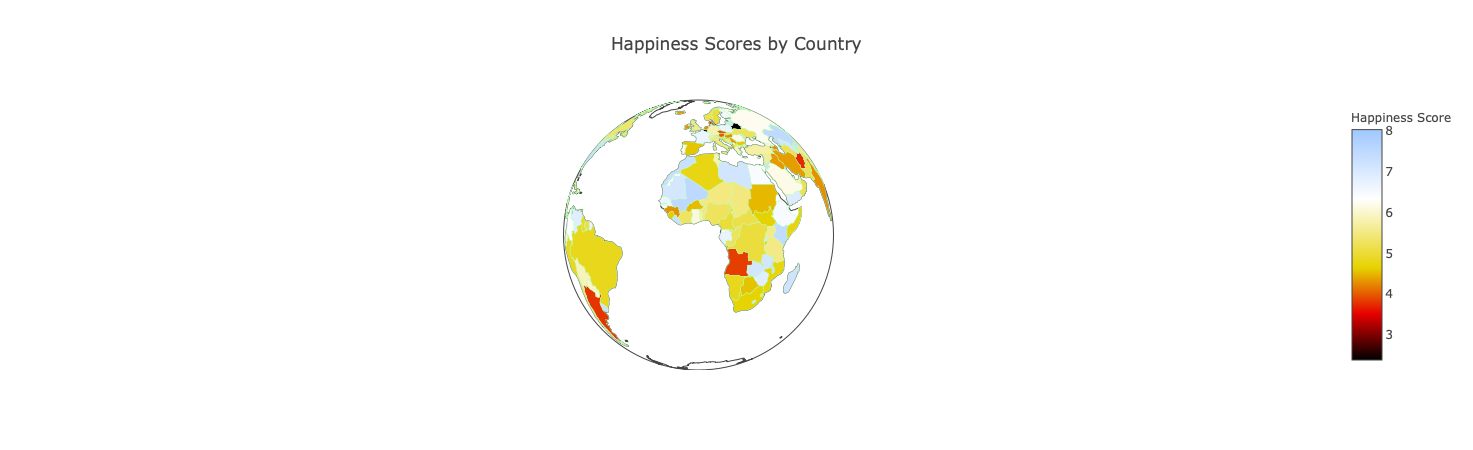

In [40]:
prep.plot_map(HappyDf, 'Life Ladder', 'Happiness Scores by Country', 'Happiness Score')

In [29]:
RateDf[['Country','suicides/100k pop']].groupby(['Country']).sum().sort_values(by = 'suicides/100k pop', ascending = False).head()

suicides/100k pop
Country                              
Russian Federation           11305.13
Lithuania                    10588.88
Hungary                      10156.07
Kazakhstan                    9519.52
Republic of Korea             9350.45

In [30]:
RateDf[['Country','suicides/100k pop']].groupby(['Country']).sum().sort_values(by = 'suicides/100k pop', ascending = True).head()

suicides/100k pop
Country                                 
Dominica                            0.00
Saint Kitts and Nevis               0.00
Oman                               26.50
United Arab Emirates               94.89
Jamaica                           106.44

In [26]:
RateDf[['Country','suicides/100k pop']].groupby(['Country']).sum().loc[['Dominica', 'Guyana', 'Paraguay', 'Suriname', 'Chile', 'Argentina', 'Brazil', 'Ecuador', 'Uruguay', 'Colombia']].sort_values(by = 'suicides/100k pop', ascending = False)

suicides/100k pop
Country                     
Suriname             7162.32
Guyana               6655.92
Uruguay              6538.96
Chile                3921.64
Argentina            3894.59
Ecuador              2345.21
Brazil               2174.72
Colombia             2009.39
Paraguay             1366.37
Dominica                0.00

Next let’s take a look at the happiness scores and suicide rates over time. 

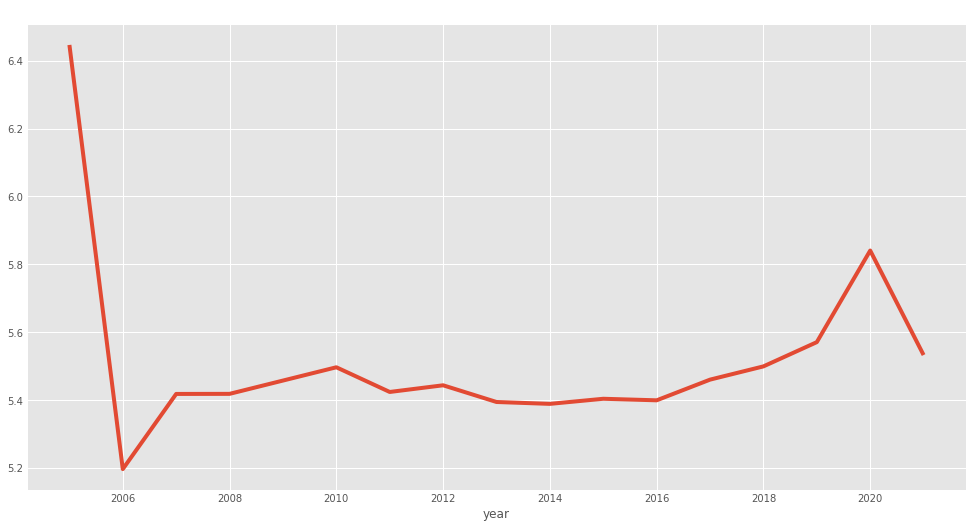

In [387]:
fig, ax = plt.subplots(figsize=(15,8))
HappyDf.groupby('year').mean()['Life Ladder'].plot(kind='line', title="Worldwide Happiness Scores");

We can see that happiness rates hit a low around 2006 worldwide and has since been trending upwards until the year 2020 where we see a sharp decline. This could likely be because of the pandemic but thats just an assumption, let’s take a look at the suicide rates next.

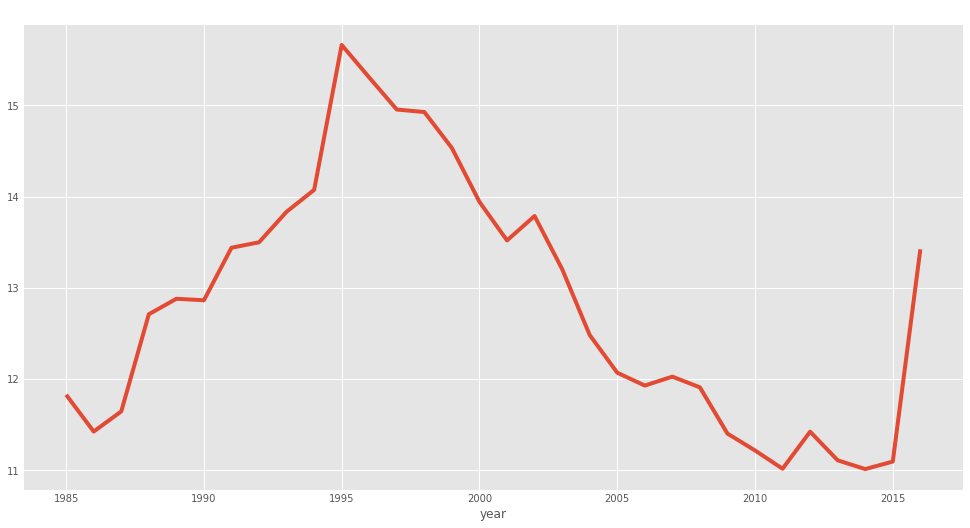

In [400]:
fig, ax = plt.subplots(figsize=(15,8))
RateDf.groupby('year').mean()['suicides/100k pop'].plot(kind='line')
plt.title('Worldwide Suicide Rates');

For suicide rates we have a longer timeframe from 1985 to 2016. We see that since the peak in the mid 1990s we have been trending downwards until around 2015 where we see an exponential increase.

Interesting start, now let’s look a little deeper into different continents to take a closer look at how each country compares to one another. 

### North and South America

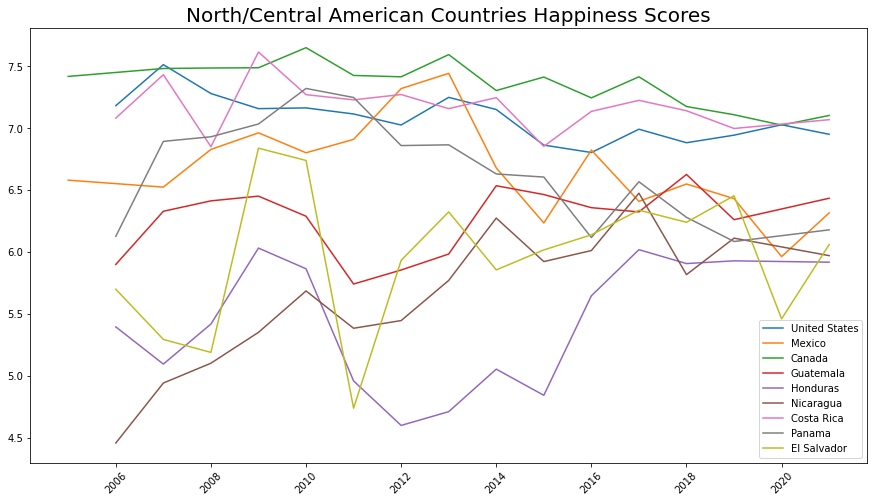

In [7]:
prep.plot_happy_N(HappyDf)
plt.title("North/Central American Countries Happiness Scores", fontsize=20);

A couple things to notice
* Canada has highest scores but on the decline in recent years.
* Nicaragua started with the lowest but saw an increase of 2 points in one decade.
* Most countries start a downward trend around 2017

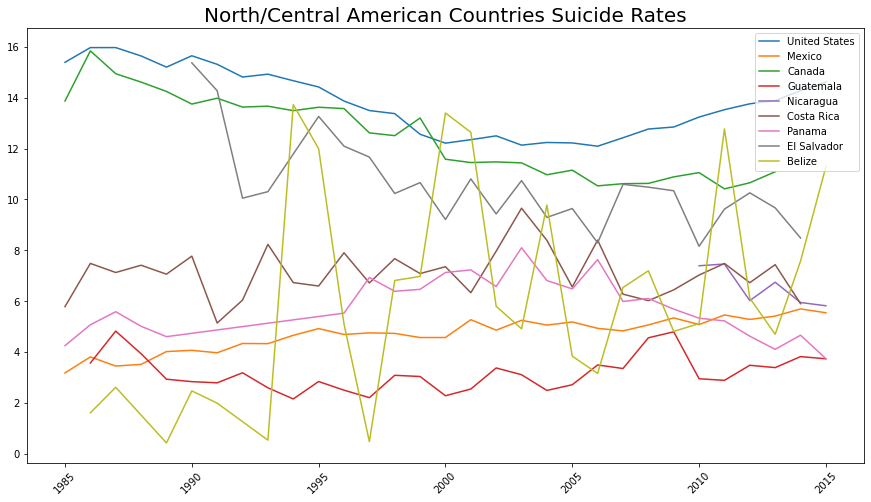

In [8]:
prep.plot_rate_N(RateDf)
plt.title("North/Central American Countries Suicide Rates", fontsize=20);

* The United States was seeing a decline in suicides until around 2005 where the trend seems to reverse
* Belize started with the lowest suicide rates but has seen an exponential increase over the years and is on its way to being the highest.
* Canada seems to be following a similar pattern as the United States 

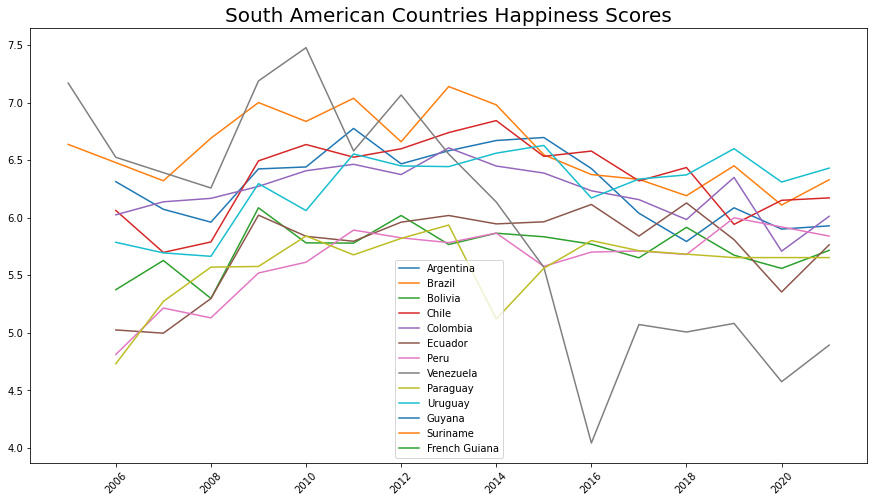

In [9]:
prep.plot_happy_S(HappyDf)
plt.title('South American Countries Happiness Scores', fontsize=20);

* All very similar trends but Venezuela seeing a sharp decline starting around 2012
* All countries peak happiness is before the year 2014 with the exception of Ecuador. 

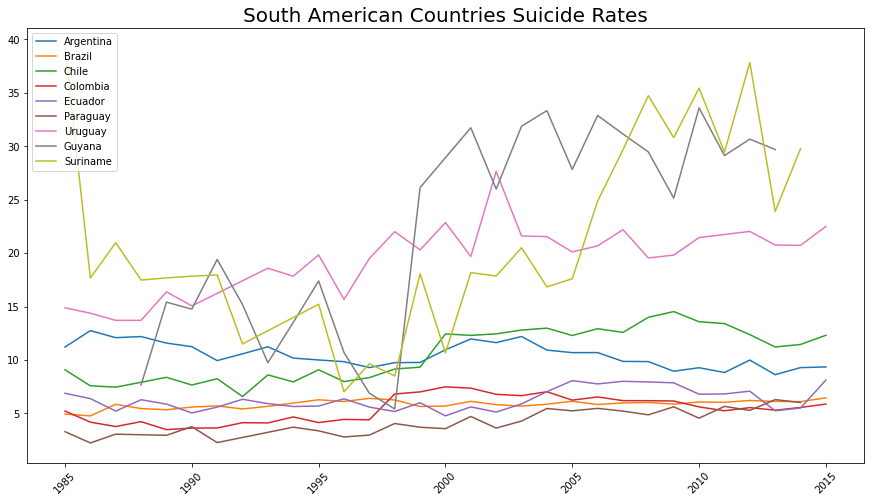

In [8]:
prep.plot_rate_S(RateDf)
plt.title('South American Countries Suicide Rates', fontsize=20);

* Rates are higher ranging to almost 40 while North America's high is around 16
* Neighboring countries Guyana and Suriname see a large increase in suicides around the same time in the late 90s

### EDA by Country

Now let’s take an even deeper look at certain countries to see a quick overview to see if we can see anything abnormal. 

Note: Some higher value features such as GDP and Inflation have been scaled down for readability. 

#### United States

Life Expectancy at Birth Average: 68.425
Happiness Score Average (0-10): 7.0815
Suicide Rate Average Per 100K: 13.819811827956988
Log GDP Per Capita Average: 10.524795596512899
Log GNI Per Capita Average: 10.49148778710336
Inflation Annual % Average: 2.6425262238698126
Foreign Investment % of GDP: 1.4811402483937215
-------------------------------------------
Perceptions of corruption: 0.6889375
Freedom to make life choices: 0.8429375
Generosity: 0.1825
Social Support: 0.9229375000000001
Rural Pop Growth % Average: -0.11044055030066484
Urban Pop Growth % Average: 1.2724578821291566
Social Safety Net Programs Adequacy Average: nan
Access to Electricity): 100.0
Access to Basic Water Services: 99.1743177137401


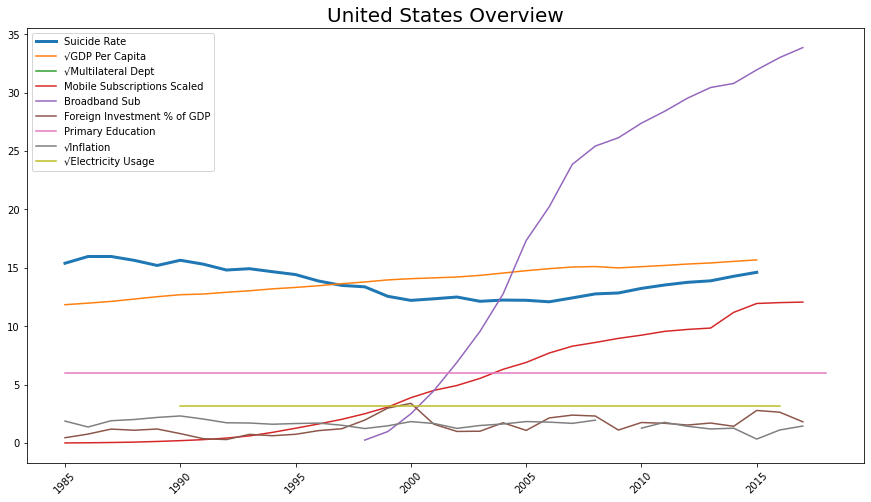

In [11]:
USA = prep.get_country_overview('United States', RateDf, HappyDf, WorldDf)

#### Canada

Life Expectancy at Birth Average: 74.3425
Happiness Score Average (0-10): 6.011625
Suicide Rate Average Per 100K: 21.57319892473118
Log GDP Per Capita Average: 10.46542286281564
Log GNI Per Capita Average: 10.434387313317387
Inflation Annual % Average: 0.559641383242504
Foreign Investment % of GDP: 0.1495917783066048
-------------------------------------------
Perceptions of corruption: 0.6930625
Freedom to make life choices: 0.8038750000000001
Generosity: -0.161375
Social Support: 0.9018125
Rural Pop Growth % Average: -2.914577143749989
Urban Pop Growth % Average: 0.7058862364775617
Social Safety Net Programs Adequacy Average: nan
Access to Electricity): 100.0
Access to Basic Water Services: 98.65214968152867


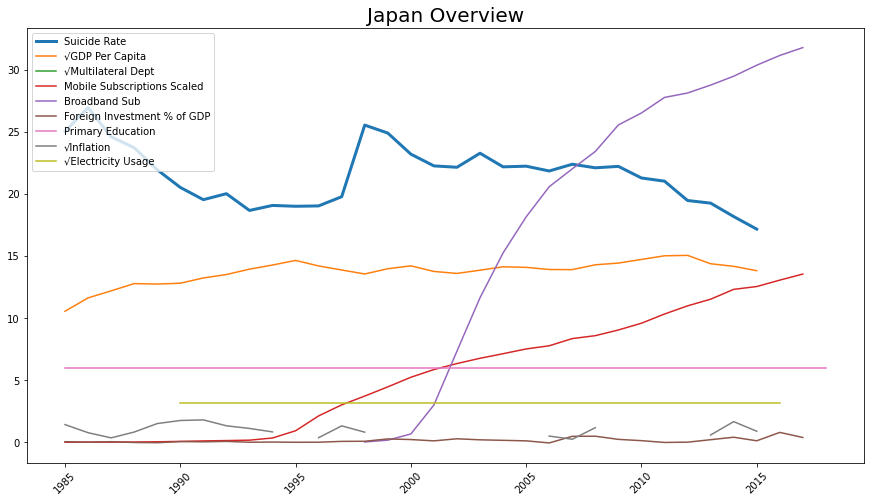

In [349]:
Canada = prep.get_country_overview('Japan', RateDf, HappyDf, WorldDf)

#### Russia

Life Expectancy at Birth Average: nan
Happiness Score Average (0-10): nan
Suicide Rate Average Per 100K: 34.89237654320988
Log GDP Per Capita Average: 8.501234294281701
Log GNI Per Capita Average: 8.466916100319562
Inflation Annual % Average: 70.2505401413391
Foreign Investment % of GDP: 1.8294033667069505
-------------------------------------------
Perceptions of corruption: nan
Freedom to make life choices: nan
Generosity: nan
Social Support: nan
Rural Pop Growth % Average: -0.27578782277223185
Urban Pop Growth % Average: 0.15316637714133577
Social Safety Net Programs Adequacy Average: 7.49401437614888
Access to Electricity): 100.0
Access to Basic Water Services: 95.81418422340636


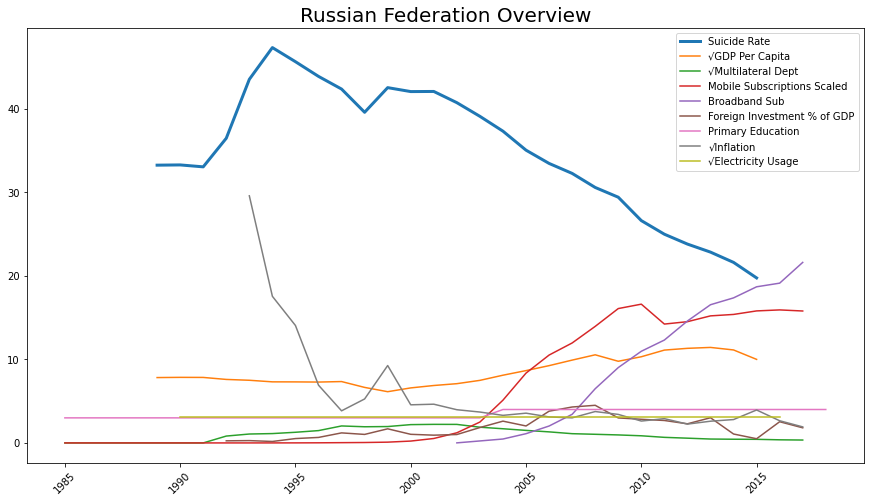

In [13]:
Russia = prep.get_country_overview('Russian Federation', RateDf, HappyDf, WorldDf)

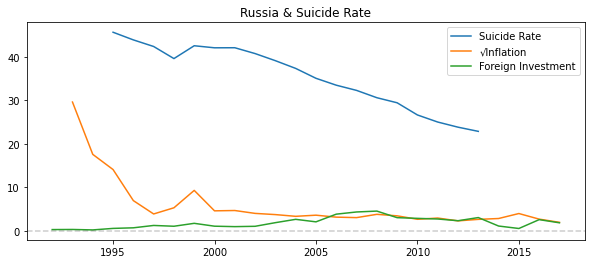

In [39]:
plt.figure(figsize=(10,4))
plt.plot(RateDf[RateDf.Country == 'Russian Federation'].set_index('year')['suicides/100k pop'].groupby('year').mean().loc[1995:2013], label='Suicide Rate')
plt.plot(np.sqrt(WorldDf[(WorldDf.Country == 'Russian Federation') & (WorldDf.IndicatorName == 'Inflation, consumer prices (annual %)')].set_index('year')['Value']), label='√Inflation')
plt.plot(WorldDf[(WorldDf.Country == 'Russian Federation') & (WorldDf.IndicatorName == 'Foreign direct investment, net inflows (% of GDP)')].set_index('year')['Value'], label='Foreign Investment')
plt.axhline(0, color='k', linestyle='--', alpha=0.2)
plt.title('Russia & Suicide Rate')
plt.legend();

#### Belize

Life Expectancy at Birth Average: 63.075125
Happiness Score Average (0-10): 4.7741875
Suicide Rate Average Per 100K: 26.58232142857143
Log GDP Per Capita Average: 7.3821957483623795
Log GNI Per Capita Average: 7.372785254490997
Inflation Annual % Average: 254.83488002412312
Foreign Investment % of GDP: 2.9313201063397227
-------------------------------------------
Perceptions of corruption: 0.9320625
Freedom to make life choices: 0.5758125000000001
Generosity: -0.115
Social Support: 0.8750625000000001
Rural Pop Growth % Average: -0.8448630422479939
Urban Pop Growth % Average: -0.142019790267433
Social Safety Net Programs Adequacy Average: 9.780068191646867
Access to Electricity): 99.38128683173146
Access to Basic Water Services: 96.65652974731809


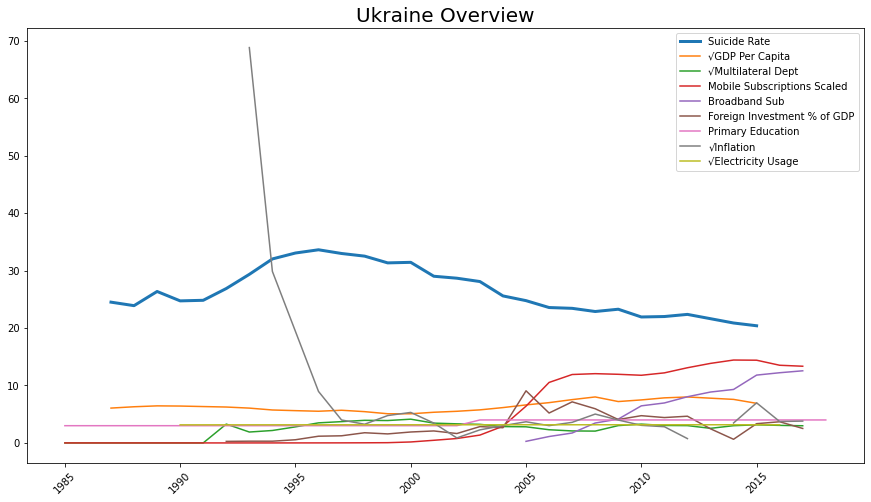

In [354]:
Belize = prep.get_country_overview('Ukraine', RateDf, HappyDf, WorldDf)

#### Colombia

Life Expectancy at Birth Average: 66.6000625
Happiness Score Average (0-10): 6.23375
Suicide Rate Average Per 100K: 5.401586021505377
Log GDP Per Capita Average: 8.022037894913149
Log GNI Per Capita Average: 7.933450780365535
Inflation Annual % Average: 13.179117562289779
Foreign Investment % of GDP: 2.9037284453804735
-------------------------------------------
Perceptions of corruption: 0.8473124999999999
Freedom to make life choices: 0.8158749999999999
Generosity: -0.083875
Social Support: 0.884875
Rural Pop Growth % Average: -0.18598149170360395
Urban Pop Growth % Average: 2.037709149694142
Social Safety Net Programs Adequacy Average: 5.32815882674435
Access to Electricity): 94.6965722600369
Access to Basic Water Services: 93.4387253582087


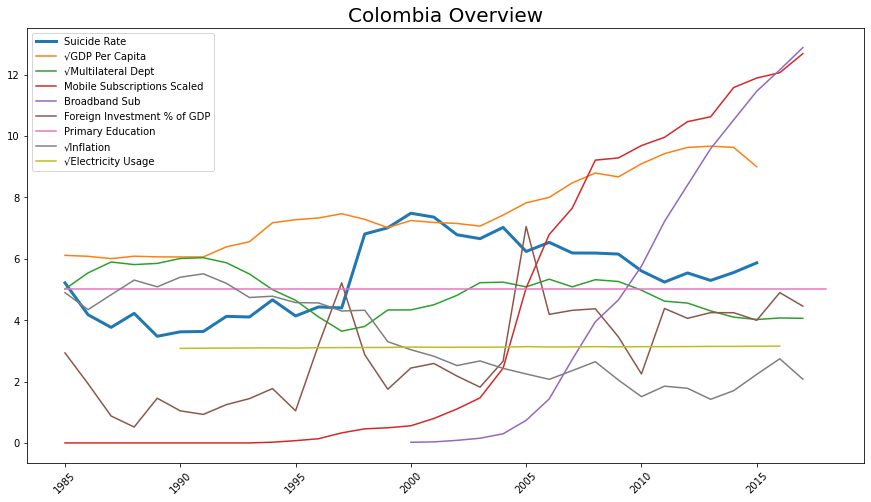

In [245]:
Colombia = prep.get_country_overview('Colombia', RateDf, HappyDf, WorldDf)

#### Nicaragua

Life Expectancy at Birth Average: nan
Happiness Score Average (0-10): nan
Suicide Rate Average Per 100K: 0.0
Log GDP Per Capita Average: 7.3031700512368
Log GNI Per Capita Average: 8.355826900671726
Inflation Annual % Average: 2.09675011202712
Foreign Investment % of GDP: 6.377406219221575
-------------------------------------------
Perceptions of corruption: nan
Freedom to make life choices: nan
Generosity: nan
Social Support: nan
Rural Pop Growth % Average: -1.3912196197559887
Urban Pop Growth % Average: 0.8396732896021659
Social Safety Net Programs Adequacy Average: 21.010731492541197
Access to Electricity): 84.66150331850406
Access to Basic Water Services: 95.365625


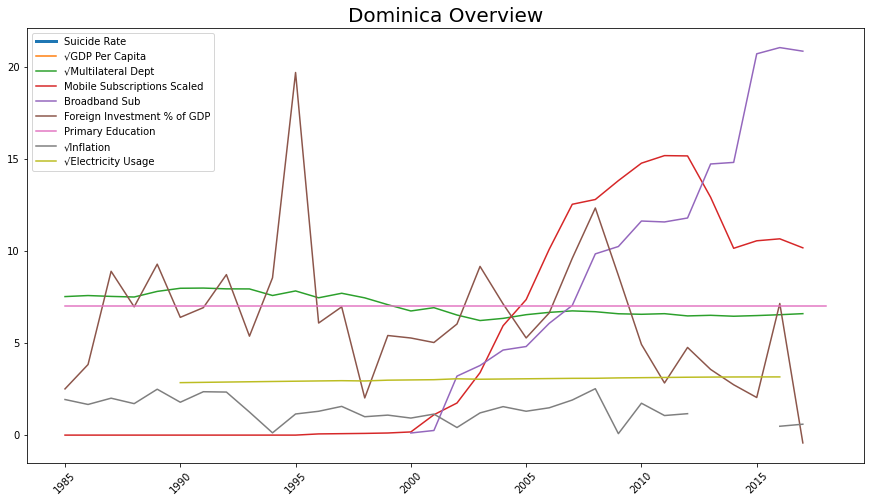

In [355]:
UK = prep.get_country_overview('Dominica', RateDf, HappyDf, WorldDf)

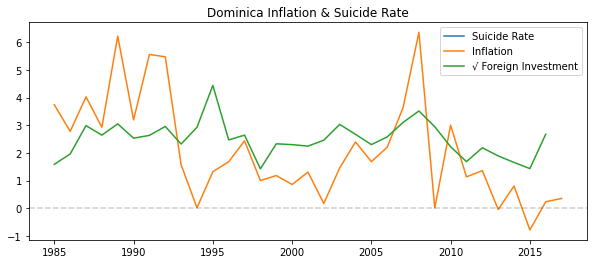

In [5]:
plt.figure(figsize=(10,4))
plt.plot(RateDf[RateDf.Country == 'Dominica'].set_index('year')['suicides/100k pop'].groupby('year').mean().loc[1995:2013], label='Suicide Rate')
plt.plot(WorldDf[(WorldDf.Country == 'Dominica') & (WorldDf.IndicatorName == 'Inflation, consumer prices (annual %)')].set_index('year')['Value'], label='Inflation')
plt.plot(np.sqrt(WorldDf[(WorldDf.Country == 'Dominica') & (WorldDf.IndicatorName == 'Foreign direct investment, net inflows (% of GDP)')].set_index('year')['Value']), label='√ Foreign Investment')
plt.axhline(0, color='k', linestyle='--', alpha=0.2)
plt.title('Dominica Inflation & Suicide Rate')
plt.legend();

#### Countries of Interest
We see that Guyana and Suriname have the highest suicide rates, while Paraguay has the lowest in South America so let’s take a more in depth view of these following countries. 

#### Guyana

Life Expectancy at Birth Average: 57.26
Happiness Score Average (0-10): 5.9929999999999986
Suicide Rate Average Per 100K: 22.186400000000003
Log GDP Per Capita Average: 7.1856259704800065
Log GNI Per Capita Average: 7.027378756884167
Inflation Annual % Average: 4.878480428788435
Foreign Investment % of GDP: 7.457842926784485
-------------------------------------------
Perceptions of corruption: 0.836
Freedom to make life choices: 0.6940000000000001
Generosity: 0.11
Social Support: 0.8490000000000001
Rural Pop Growth % Average: 0.16195808122676314
Urban Pop Growth % Average: -0.37377581452871006
Social Safety Net Programs Adequacy Average: nan
Access to Electricity): 76.22949086912439
Access to Basic Water Services: 91.5331250892575


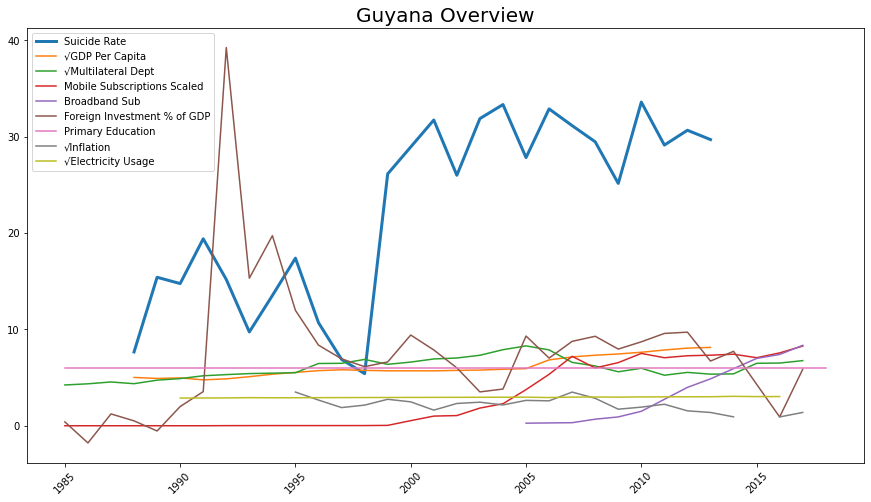

In [16]:
Guyana = prep.get_country_overview('Guyana', RateDf, HappyDf, WorldDf)

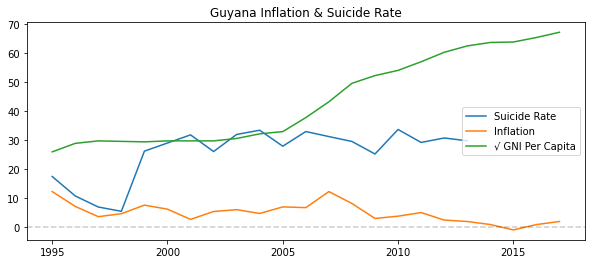

In [3]:
plt.figure(figsize=(10,4))
plt.plot(RateDf[RateDf.Country == 'Guyana'].set_index('year')['suicides/100k pop'].groupby('year').mean().loc[1995:2013], label='Suicide Rate')
plt.plot(WorldDf[(WorldDf.Country == 'Guyana') & (WorldDf.IndicatorName == 'Inflation, consumer prices (annual %)')].set_index('year')['Value'], label='Inflation')
plt.plot(np.sqrt(WorldDf[(WorldDf.Country == 'Guyana') & (WorldDf.IndicatorName == 'GNI per capita, Atlas method (current US$)')].set_index('year')['Value'].loc[1995:]), label='√ GNI Per Capita')
plt.axhline(0, color='k', linestyle='--', alpha=0.2)
plt.title('Guyana Inflation & Suicide Rate')
plt.legend(loc=7);

#### Suriname

Life Expectancy at Birth Average: 62.24
Happiness Score Average (0-10): 6.269
Suicide Rate Average Per 100K: 21.31642857142857
Log GDP Per Capita Average: 8.125666613257696
Log GNI Per Capita Average: 7.997339894739712
Inflation Annual % Average: 41.275728406537084
Foreign Investment % of GDP: -5.335820786842539
-------------------------------------------
Perceptions of corruption: 0.7509999999999999
Freedom to make life choices: 0.885
Generosity: -0.077
Social Support: 0.797
Rural Pop Growth % Average: 1.2244483253972562
Urban Pop Growth % Average: 1.3295356135631797
Social Safety Net Programs Adequacy Average: nan
Access to Electricity): 94.8504330798806
Access to Basic Water Services: 92.33743150364587


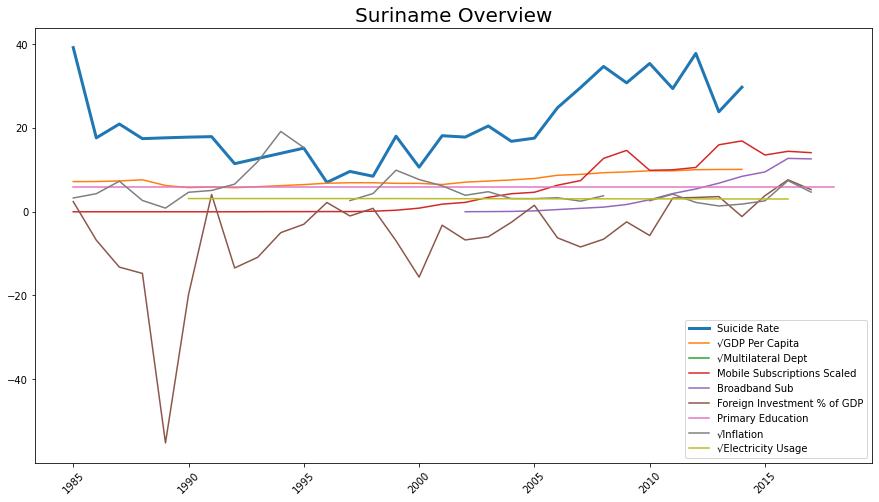

In [17]:
Suriname = prep.get_country_overview('Suriname', RateDf, HappyDf, WorldDf)

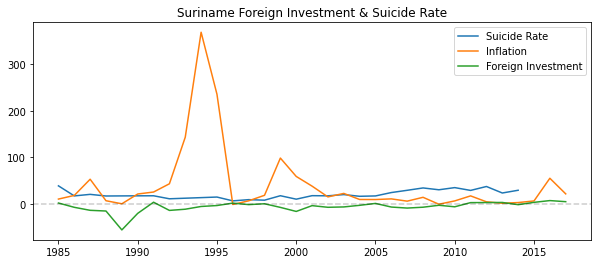

In [35]:
plt.figure(figsize=(10,4))
plt.plot(RateDf[RateDf.Country == 'Suriname'].set_index('year')['suicides/100k pop'].groupby('year').mean(), label='Suicide Rate')
plt.plot(WorldDf[(WorldDf.Country == 'Suriname') & (WorldDf.IndicatorName == 'Inflation, consumer prices (annual %)')].set_index('year')['Value'], label='Inflation')
plt.plot(WorldDf[(WorldDf.Country == 'Suriname') & (WorldDf.IndicatorName == 'Foreign direct investment, net inflows (% of GDP)')].set_index('year')['Value'].interpolate(), label='Foreign Investment')
plt.axhline(0, color='k', linestyle='--', alpha=0.2)
plt.title('Suriname Foreign Investment & Suicide Rate')
plt.legend();

#### Paraguay

Life Expectancy at Birth Average: 64.8
Happiness Score Average (0-10): 5.565785714285716
Suicide Rate Average Per 100K: 4.217191358024691
Log GDP Per Capita Average: 7.657424096083206
Log GNI Per Capita Average: 7.848584448141161
Inflation Annual % Average: 12.40665451409895
Foreign Investment % of GDP: 1.1047760840886482
-------------------------------------------
Perceptions of corruption: 0.8347857142857142
Freedom to make life choices: 0.7762857142857144
Generosity: 0.05521428571428572
Social Support: 0.9053571428571427
Rural Pop Growth % Average: 0.853197393783093
Urban Pop Growth % Average: 2.947391671292183
Social Safety Net Programs Adequacy Average: 13.799886355329575
Access to Electricity): 91.29136785675276
Access to Basic Water Services: 87.32253150702837


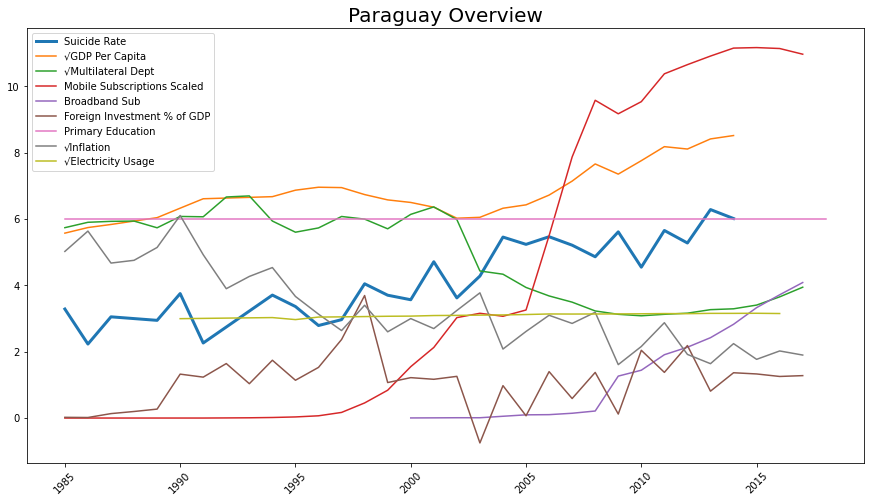

In [18]:
Paraguay = prep.get_country_overview('Paraguay', RateDf, HappyDf, WorldDf)

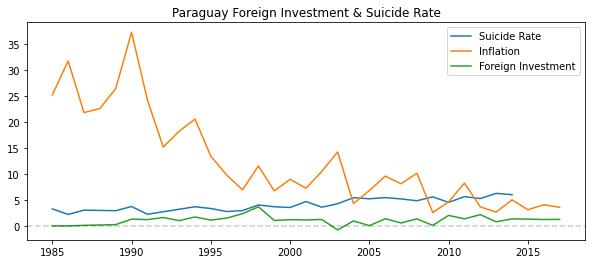

In [34]:
plt.figure(figsize=(10,4))
plt.plot(RateDf[RateDf.Country == 'Paraguay'].set_index('year')['suicides/100k pop'].groupby('year').mean(), label='Suicide Rate')
plt.plot(WorldDf[(WorldDf.Country == 'Paraguay') & (WorldDf.IndicatorName == 'Inflation, consumer prices (annual %)')].set_index('year')['Value'], label='Inflation')
plt.plot(WorldDf[(WorldDf.Country == 'Paraguay') & (WorldDf.IndicatorName == 'Foreign direct investment, net inflows (% of GDP)')].set_index('year')['Value'].interpolate(), label='Foreign Investment')
plt.axhline(0, color='k', linestyle='--', alpha=0.2)
plt.title('Paraguay Foreign Investment & Suicide Rate')
plt.legend();

In [19]:
World_Overview = prep.get_world_overview(RateDf, HappyDf, WorldDf)

Life Expectancy at Birth Average: 62.855488107316795
Happiness Score Average (0-10): 5.43152168367347
Suicide Rate Average Per 100K: 11.51421875
Log GDP Per Capita Average: 9.620263626763
Log GNI Per Capita Average: 8.487279977306615
Inflation Annual % Average: 5.31226206771533
Foreign Investment % of GDP: 5.9855480262759935
-------------------------------------------
Perceptions of corruption: 0.7492286267144845
Freedom to make life choices: 0.7298852040816327
Generosity: 0.004366523171768704
Social Support: 0.8109151785714285
Rural Pop Growth % Average: 0.4184128587661824
Urban Pop Growth % Average: 2.109200376375242
Social Safety Net Programs Adequacy Average: 10.014306870986822
Access to Electricity: 79.79457617500604
Access to Basic Water Services: 85.27919395128757


***
### Model Preprocessing


We start off by creating categorical variables for our suicide dataset and ordering our data frames by country and year in the index. We then drop all the years in our categorical dataset and only keep the most recent year to combine the categorical data frame with our continuous variables data frame which in turn gives us one clean processed data frame

In [20]:
# Make copy wiht only categorical variables
RateCat = RateDf.copy().set_index(['Country', 'year'])[['sex', 'age', 'generation']]

# Initiate label encoder and apply to our categorical columns.
le = LabelEncoder()
RateCat['sex'] = le.fit_transform(RateCat['sex'])
RateCat['age'] = le.fit_transform(RateCat['age'])
RateCat['generation'] = le.fit_transform(RateCat['generation'])
RateCat.reset_index(inplace=True)

# Drop all but keep the last categorical data for each year(each year has 12 different categories for data so only keep the last for each)
RateCat.drop_duplicates(subset=['Country', 'year'], keep='last', inplace=True)

#Create dataframe with continuous variables and drop population as it's not relevent and could cause multicollenuarity issues. 
RateCon = RateDf.copy().groupby(['Country', 'year']).mean().drop(columns='population')


In [21]:
# Merge the two dataframes on country and year as our index. 
RateCon = RateCon.merge(RateCat, how='outer', on=['Country', 'year']).groupby(['Country', 'year']).mean()

Our world dataset does not have a target variable, only features to use as predictors for either suicide rates or happiness scores. I've manually gone through over a thousand features and tried to find only relevant features to our business problem and didn't have too many missing values.

We iterate through the dataset and create a temp data frame out of a feature then combine them all into one under the same index country and year while printing a preview of the feature mean for the world. 

In [23]:
features = ['Urban population growth (annual %)', 'Rural population growth (annual %)', 'Mobile cellular subscriptions (per 100 people)',
            'Fixed broadband subscriptions (per 100 people)', 'Foreign direct investment, net inflows (% of GDP)', 'GNI per capita, Atlas method (current US$)', 'Primary education, duration (years)', 
           'Inflation, consumer prices (annual %)', 'Access to electricity (% of population)',
           'People using at least basic drinking water services (% of population)']

def get_world_df(features):
    
    listi = []
    
    for name in features:
        name = WorldDf[WorldDf.IndicatorName == name].drop(columns='IndicatorName').groupby(['Country', 'year']).mean().rename(columns={'Value': name})
        print(name.mean())
        listi.append(name)
    return listi
world = get_world_df(features)

World_Over = pd.concat(world).groupby(['Country', 'year']).mean()

Urban population growth (annual %)    2.37697
dtype: float64
Rural population growth (annual %)    0.480022
dtype: float64
Mobile cellular subscriptions (per 100 people)    38.65041
dtype: float64
Fixed broadband subscriptions (per 100 people)    8.618271
dtype: float64
Foreign direct investment, net inflows (% of GDP)    4.055229
dtype: float64
GNI per capita, Atlas method (current US$)    8883.122807
dtype: float64
Primary education, duration (years)    5.699107
dtype: float64
Inflation, consumer prices (annual %)    25.482019
dtype: float64
Access to electricity (% of population)    75.036003
dtype: float64
People using at least basic drinking water services (% of population)    84.189864
dtype: float64


***
Our last dataset with happiness features and our happiness score target('Life Ladder'). We set the same index for our data to be able to merge in the right locations then merge it with our suicide dataset. Finally we merge that dataset with the world features dataset to create one cohesive data frame dropping any values that are missing. Doing this will remove some data and/or years but we will be left with only valid data from all 3 data frames. 

In [24]:
HappyDf = HappyDf.groupby(['Country', 'year']).mean()

In [25]:
HappyRate = HappyDf.merge(RateCon, on=['Country', 'year']).groupby(['Country', 'year']).mean().dropna()

In [26]:
AllThree = World_Over.merge(HappyRate, on=['Country', 'year']).groupby(['Country', 'year']).mean().dropna() #.reset_index()

In [27]:
AllThree

Urban population growth (annual %)  \
Country year                                       
Albania 2007                            1.492215   
        2009                            1.473288   
        2010                            1.609373   
Armenia 2007                           -1.020503   
        2008                           -1.005844   
...                                          ...   
Uruguay 2010                            0.563495   
        2012                            0.463024   
        2013                            0.439699   
        2014                            0.445567   
        2015                            0.455764   

              Rural population growth (annual %)  \
Country year                                       
Albania 2007                           -2.860734   
        2009                           -2.867396   
        2010                           -2.743291   
Armenia 2007                           -0.587614   
        2008                           -0.577658   
...                                          ...   
Uruguay 2010                           -3.257845   
        2012                           -2.056447   
        2013                           -1.666259   
        2014                           -1.659777   
        2015                           -1.647791   

              Mobile cellular subscriptions (per 100 people)  \
Country year                                                   
Albania 2007                                       76.802494   
        2009                                       83.160464   
        2010                                       91.560929   
Armenia 2007                                       63.974605   
        2008                                       49.583594   
...                                                      ...   
Uruguay 2010                                      131.494140   
        2012                                      147.064673   
        2013                                      154.575683   
        2014                                      160.755083   
        2015                                      150.528799   

              Fixed broadband subscriptions (per 100 people)  \
Country year                                                   
Albania 2007                                        0.330698   
        2009                                        3.105344   
        2010                                        3.589121   
Armenia 2007                                        0.132967   
        2008                                        0.474483   
...                                                      ...   
Uruguay 2010                                       11.366385   
        2012                                       17.094705   
        2013                                       21.627844   
        2014                                       24.572297   
        2015                                       26.254389   

              Foreign direct investment, net inflows (% of GDP)  \
Country year                                                      
Albania 2007                                           6.108980   
        2009                                          11.160187   
        2010                                           9.139898   
Armenia 2007                                           7.252332   
        2008                                           8.092349   
...                                                         ...   
Uruguay 2010                                           5.438988   
        2012                                          11.789672   
        2013                                           1.312569   
        2014                                           6.692390   
        2015                                           4.566225   

              GNI per capita, Atlas method (current US$)  \
Country year                                               
Al

# Modeling

#### Suicide Rates

For modeling we first dive into suicide rates to build a inferential model which should be able to predict suicides based on our features. 

Our first model will be a Support Vector Regressor fitting a linear, polynomial and RBF(Radial basis function)

In [28]:
y = AllThree["suicides/100k pop"]

X = AllThree.drop('suicides/100k pop', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=789)


start = time()
lin_svr = SVR(kernel='linear', C=1000)
lin_svr.fit(X_train, y_train)
poly_svr = SVR(kernel='poly', C=1000, degree=2)
poly_svr.fit(X_train, y_train)
rbf_svr = SVR(kernel='rbf', C=1000, gamma=.15)
rbf_svr.fit(X_train, y_train)


print(cross_validate(lin_svr, X_train, y_train, cv=5, scoring='r2'))
print(cross_validate(poly_svr, X_train, y_train, cv=5, scoring='r2'))
print(cross_validate(rbf_svr, X_train, y_train, cv=5, scoring='r2'))
end = time()
print("Fitting Time:", end - start)

{'fit_time': array([297.38756728, 475.20838976, 280.94437909, 259.80389977,
       297.47115612]), 'score_time': array([0.00323772, 0.00379729, 0.00323081, 0.00406098, 0.00415611]), 'test_score': array([-4.13087856e+08, -2.91900506e+09, -1.80356323e+09, -7.78423112e+08,
       -3.49227094e+08])}
{'fit_time': array([0.27166891, 0.22519016, 0.25240588, 0.24862885, 0.54840803]), 'score_time': array([0.00340891, 0.00345397, 0.00342703, 0.00752211, 0.00341892]), 'test_score': array([ 0.03276104, -0.16039527, -0.26923905,  0.01087187, -0.26672509])}
{'fit_time': array([0.01361775, 0.01152205, 0.01306701, 0.01067185, 0.01283979]), 'score_time': array([0.00366998, 0.00349998, 0.00320506, 0.0033741 , 0.00458312]), 'test_score': array([-0.01925614, -0.00012237, -0.00813595, -0.0196754 , -0.02780063])}
Fitting Time: 2178.759348154068


Well that is interesting, let's move on to a random forest regressor to see if we can obtain more accurate results. 

In [29]:
# Initiate a base random forest regresssor, fit and ckeck our scores. 
rf = RandomForestRegressor(random_state=789, n_estimators=1000, min_samples_split=2)

y = AllThree["suicides/100k pop"]

X = AllThree.drop('suicides/100k pop', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=789)

start = time()
rmodel = rf.fit(X_train, y_train)
end = time()
print("Fitting Time:", end - start)

Fitting Time: 5.147593975067139


In [30]:
print('Training Accuracy: ', rmodel.score(X_train, y_train))
print('Test Accuracy: ', rmodel.score(X_test, y_test))

Training Accuracy:  0.9648371789873588
Test Accuracy:  0.7860474090302263


Not too bad, now let’s cross validate it using r2 to see how our target is represented by our features. 

In [31]:
print(cross_validate(rmodel, X_train, y_train, cv=5, scoring='r2'))

{'fit_time': array([4.15909696, 4.04799199, 4.08014417, 4.02044606, 4.22346187]), 'score_time': array([0.11049604, 0.11217213, 0.10789776, 0.10923195, 0.12915516]), 'test_score': array([0.66040474, 0.79189676, 0.59715909, 0.80010014, 0.59636637])}


A little variation, let's see if we can improve those results by plugging our model into a grid-search. 

In [32]:
def forest_reg(X_train, y_train):
# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': (3,7,15,500),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='r2', verbose=0, n_jobs=-1)
    
    grid = gsc.fit(X_train, y_train)
    params = grid.best_params_
    
    rmodel = RandomForestRegressor(max_depth=params["max_depth"], n_estimators=params["n_estimators"], random_state=789, verbose=False)
   
    scores = cross_val_score(rmodel, X_train, y_train, cv=10, scoring='r2')

    return scores

In [33]:
forest_reg(X_train, y_train)

array([0.58464516, 0.81811805, 0.73022666, 0.83348775, 0.72419594,
       0.51303597, 0.85676084, 0.80240178, 0.52542745, 0.68332336])

In [34]:
scores = cross_val_score(rmodel, X_train, y_train, cv=10, scoring='r2')
predictions = cross_val_predict(rmodel, X_train, y_train, cv=10)

Much better, let’s take a look at our most important features. 

In [36]:
feature_names = X_train.columns
importance = rmodel.feature_importances_

print("Feature Importances:")
for i, data_class in enumerate(feature_names):
    print("{} ({})".format(data_class, importance[i]))

Feature Importances:
Urban population growth (annual %) (0.30312632951067026)
Rural population growth (annual %) (0.02074596255259502)
Mobile cellular subscriptions (per 100 people) (0.023023486171258833)
Fixed broadband subscriptions (per 100 people) (0.014470929571410173)
Foreign direct investment, net inflows (% of GDP) (0.019116603805325438)
GNI per capita, Atlas method (current US$) (0.011779041604677645)
Primary education, duration (years) (0.011400079059054487)
Inflation, consumer prices (annual %) (0.018476640171185)
Access to electricity (% of population) (0.006155443141806823)
People using at least basic drinking water services (% of population) (0.04051922766666841)
Life Ladder (0.0357041523141238)
Log GDP per capita (0.027637051602333453)
Social support (0.03399139485346362)
Healthy life expectancy at birth (0.16823170105435553)
Freedom to make life choices (0.02693467460235916)
Generosity (0.09821836806859202)
Perceptions of corruption (0.017728900650353284)
suicides_no (0

Lets plug it into a OLS to see how our features are reflected

In [37]:
X_int = sm.add_constant(X_train)
mod1 = sm.OLS(y_train, X_int).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      suicides/100k pop   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     13.20
Date:                Wed, 01 Dec 2021   Prob (F-statistic):           1.79e-34
Time:                        21:51:32   Log-Likelihood:                -1218.3
No. Observations:                 389   AIC:                             2483.
Df Residuals:                     366   BIC:                             2574.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================================
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
const                                                                   -20.2569     12.796     -1.583      0.114     -45.420       4.906
Urban population growth (annual %)                                       -1.7345      0.285     -6.078      0.000      -2.296      -1.173
Rural population growth (annual %)                                       -0.2440      0.210     -1.161      0.247      -0.657       0.169
Mobile cellular subscriptions (per 100 people)                            0.0119      0.013      0.940      0.348      -0.013       0.037
Fixed broadband subscriptions (per 100 people)                            0.0234      0.062      0.376      0.707      -0.099       0.146
Foreign direct investment, net inflows (% of GDP)                        -0.0121      0.033     -0.366      0.715      -0.077       0.053
GNI per capita, Atlas method (current US$)                            -3.301e-05   8.22e-05     -0.401      0.688      -0.000       0.000
Primary education, duration (years)                                      -1.4992      0.386     -3.885      0.000      -2.258      -0.740
Inflation, consumer prices (annual %)                                     0.1715      0.072      2.376      0.018       0.030       0.313
Access to electricity (% of population)                                   0.0846      0.113      0.751      0.453      -0.137       0.306
People using at least basic drinking water services (% of population)    -0.1462      0.129     -1.131      0.259      -0.400       0.108
Life Ladder                                                              -1.1471      0.576     -1.992      0.047      -2.279      -0.015
Log GDP per capita                                                        3.7680      1.552      2.428      0.016       0.716       6.820
Social support                                                           28.1744      6.115      4.608      0.000      16.150      40.199
Healthy life expectancy at birth                                         -0.1640      0.130     -1.267      0.206      -0.419       0.091
Freedom to make life choices                                              7.9133      3.519      2.249      0.025       0.994      14.833
Generosity                                                               -6.6553      2.242     -2.969      0.003     -11.064      -2.247
Perceptions of corruption                                                -0.2777      2.466     -0.113      0.910      -5.126       4.571
suicides_no                                                               0.0006      0.001      0.974      0.331      -0.001       0.002
gdp_per_capita ($)                             

#### Happiness Scores

Great! Now we can do the same thing for happiness to see the other side our business problem, what makes people happy. 

In [38]:
rf = RandomForestRegressor(random_state=789, min_samples_split=2)

y = AllThree["Life Ladder"]

X = AllThree.drop(["Life Ladder"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=789)

feature_names = X_train.columns

start = time()
rmodel = rf.fit(X_train, y_train)
end = time()
print("Fitting Time:", end - start)

Fitting Time: 0.6591711044311523


In [39]:
print('Training Accuracy: ', rmodel.score(X_train, y_train))
print('Test Accuracy: ', rmodel.score(X_test, y_test))

Training Accuracy:  0.977799205604553
Test Accuracy:  0.8847311613325028


In [40]:
forest_reg(X_train, y_train)

array([0.89194084, 0.7326149 , 0.87530835, 0.88910968, 0.86385335,
       0.73308558, 0.84385528, 0.8187028 , 0.89719795, 0.86085633])

In [41]:
feature_names = X_train.columns
importance = rmodel.feature_importances_

print("Feature Importances:")
for i, data_class in enumerate(feature_names):
    print("{} ({})".format(data_class, importance[i]))

Feature Importances:
Urban population growth (annual %) (0.03101111591123174)
Rural population growth (annual %) (0.018823852350846108)
Mobile cellular subscriptions (per 100 people) (0.013219843099504547)
Fixed broadband subscriptions (per 100 people) (0.01402535658046873)
Foreign direct investment, net inflows (% of GDP) (0.012874498446448994)
GNI per capita, Atlas method (current US$) (0.01126664076488283)
Primary education, duration (years) (0.003030846467006228)
Inflation, consumer prices (annual %) (0.008884548508452893)
Access to electricity (% of population) (0.01705024165991682)
People using at least basic drinking water services (% of population) (0.034323941606521975)
Log GDP per capita (0.13819563203340293)
Social support (0.019741186476039917)
Healthy life expectancy at birth (0.08096285649234222)
Freedom to make life choices (0.23802929409525758)
Generosity (0.016825768936520113)
Perceptions of corruption (0.014534091041017038)
suicides_no (0.01986559159247197)
suicides/1

In [42]:
X_int = sm.add_constant(X_train)
mod1 = sm.OLS(y_train, X_int).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Life Ladder   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     45.73
Date:                Wed, 01 Dec 2021   Prob (F-statistic):           6.83e-91
Time:                        21:52:50   Log-Likelihood:                -282.86
No. Observations:                 389   AIC:                             611.7
Df Residuals:                     366   BIC:                             702.9
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================================
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
const                                                                    -2.9104      1.149     -2.532      0.012      -5.171      -0.650
Urban population growth (annual %)                                       -0.0075      0.027     -0.278      0.781      -0.061       0.046
Rural population growth (annual %)                                        0.0051      0.019      0.270      0.788      -0.032       0.043
Mobile cellular subscriptions (per 100 people)                         -6.19e-05      0.001     -0.054      0.957      -0.002       0.002
Fixed broadband subscriptions (per 100 people)                           -0.0184      0.006     -3.323      0.001      -0.029      -0.008
Foreign direct investment, net inflows (% of GDP)                        -0.0027      0.003     -0.918      0.359      -0.009       0.003
GNI per capita, Atlas method (current US$)                             9.595e-06   7.41e-06      1.295      0.196   -4.98e-06    2.42e-05
Primary education, duration (years)                                       0.0024      0.036      0.066      0.947      -0.068       0.072
Inflation, consumer prices (annual %)                                     0.0014      0.007      0.217      0.828      -0.011       0.014
Access to electricity (% of population)                                  -0.0235      0.010     -2.330      0.020      -0.043      -0.004
People using at least basic drinking water services (% of population)     0.0134      0.012      1.146      0.253      -0.010       0.036
Log GDP per capita                                                        0.2784      0.141      1.981      0.048       0.002       0.555
Social support                                                            3.0243      0.545      5.544      0.000       1.952       4.097
Healthy life expectancy at birth                                          0.0692      0.011      6.208      0.000       0.047       0.091
Freedom to make life choices                                              1.6671      0.308      5.416      0.000       1.062       2.272
Generosity                                                                0.4139      0.204      2.032      0.043       0.013       0.815
Perceptions of corruption                                                -1.0238      0.216     -4.737      0.000      -1.449      -0.599
suicides_no                                                             5.51e-05   5.28e-05      1.044      0.297   -4.87e-05       0.000
suicides/100k pop                                                        -0.0094      0.005     -1.992      0.047      -0.019      -0.000
gdp_per_capita ($)                             

In [79]:
HappyDf

Country  year  Life Ladder  Log GDP per capita  Social support  \
0     Afghanistan  2008        3.724               7.370           0.451   
1     Afghanistan  2009        4.402               7.540           0.552   
2     Afghanistan  2010        4.758               7.647           0.539   
3     Afghanistan  2011        3.832               7.620           0.521   
4     Afghanistan  2012        3.783               7.705           0.521   
...           ...   ...          ...                 ...             ...   
2093      Lesotho  2021        3.512               7.926           0.787   
2094     Botswana  2021        3.467               9.782           0.784   
2095       Rwanda  2021        3.415               7.676           0.552   
2096     Zimbabwe  2021        3.145               7.943           0.750   
2097  Afghanistan  2021        2.523               7.695           0.463   

      Healthy life expectancy at birth  Freedom to make life choices  \
0                               50.800                         0.718   
1                               51.200                         0.679   
2                               51.600                         0.600   
3                               51.920                         0.496   
4                               52.240                         0.531   
...                                ...                           ...   
2093                            48.700                         0.715   
2094                            59.269                         0.824   
2095                            61.400                         0.897   
2096                            56.201                         0.677   
2097                            52.493                         0.382   

      Generosity  Perceptions of corruption  
0          0.168                      0.882  
1          0.190                      0.850  
2          0.121                      0.707  
3          0.162                      0.731  
4          0.236                      0.776  
...          ...                        ...  
2093      -0.131                      0.915  
2094      -0.246                      0.801  
2095       0.061                      0.167  
2096      -0.047                      0.821  
2097      -0.102                      0.924  

[2098 rows x 9 columns]

### Time Series

In [80]:
Happy = HappyDf.copy()
Happy.reset_index(inplace=True)
Happy.year = Happy.year.astype(str)
Happy.year = pd.to_datetime(Happy.year)
Happy.set_index('year', inplace=True)
ts_happ = Happy['Life Ladder'].groupby('year').mean().sort_index().interpolate().loc['2006':'2021']

In [81]:
ts_happ

year
2006-01-01    5.196899
2007-01-01    5.418275
2008-01-01    5.418509
2009-01-01    5.457667
2010-01-01    5.496806
2011-01-01    5.424082
2012-01-01    5.443754
2013-01-01    5.394562
2014-01-01    5.389021
2015-01-01    5.404035
2016-01-01    5.399479
2017-01-01    5.460408
2018-01-01    5.499444
2019-01-01    5.570868
2020-01-01    5.840600
2021-01-01    5.532839
Name: Life Ladder, dtype: float64

In [82]:
# RateDf['year'] = pd.to_datetime(RateDf['year'].astype(str))
# RateDf = RateDf.groupby(['Country','year']).mean()
# ts_rate = RateDf['suicides/100k pop'].groupby('year').mean()
naive = ts_happ.shift(1)

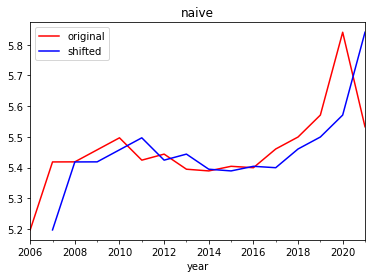

In [83]:
fig, ax = plt.subplots()

ts_happ.plot(ax=ax, c='r', label='original')
naive.plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

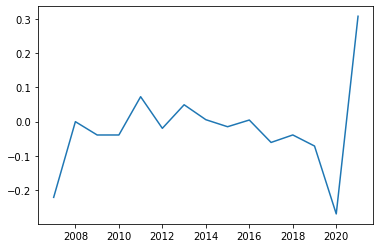

In [84]:
fig, ax = plt.subplots()
residuals = naive[1:] - ts_happ[1:]
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(1).std());

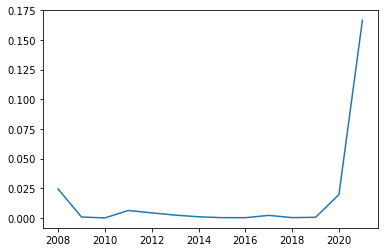

In [85]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(2).var());

In [86]:
p_val = adfuller(ts_happ.diff()[1:])[1]
print(f"The p-value is {p_val},")
if p_val < 0.05:
    print("We can safely assume that the differenced data is stationary.")
else:
    print("We cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value is 0.9470708963446421,
We cannot reject the null hypothesis that the differenced data is not stationary.


In [87]:
ar_1 = ARIMA(ts_happ, order=(0, 1, 0)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
ar_1.predict(typ='levels')
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Life Ladder   No. Observations:                   16
Model:                 ARIMA(0, 1, 0)   Log Likelihood                   9.784
Date:                Thu, 02 Dec 2021   AIC                            -17.569
Time:                        23:31:07   BIC                            -16.861
Sample:                    01-01-2006   HQIC                           -17.576
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0159      0.004      3.584      0.000       0.007       0.025
===================================================================================
Ljung-Box (L1) (Q):                   1.79   Jarque-Bera (JB):                 2.81
Prob(Q):                              0.18   Prob(JB):                         0.25
Heteroskedasticity (H):               3.10   Skew:                            -0.49
Prob(H) (two-sided):                  0.24   Kurtosis:                         4.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [88]:
ts_happ = ts_happ.resample('M').mean().interpolate()

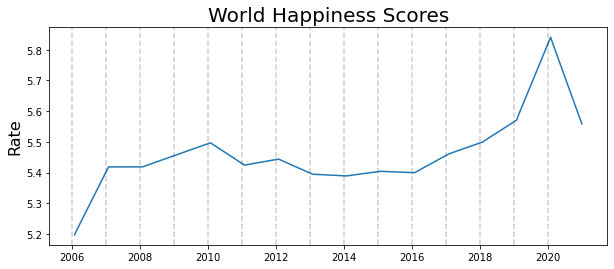

In [89]:
world_happ = ts_happ.asfreq(pd.infer_freq(ts_happ.index))

start_date = datetime(2006,1,1)
end_date = datetime(2021,1,1)
lim_world_happ = world_happ[start_date:end_date]

plt.figure(figsize=(10,4))
plt.plot(lim_world_happ)
plt.title('World Happiness Scores', fontsize=20)
plt.ylabel('Rate', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

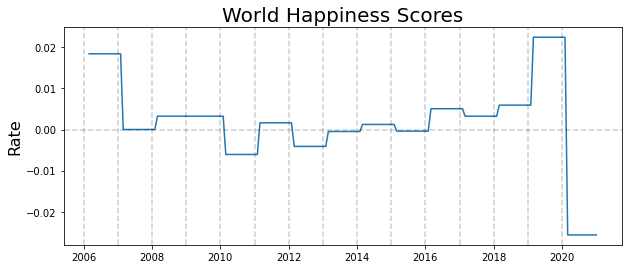

In [90]:
first_diff = lim_world_happ.diff()[1:]

plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('World Happiness Scores', fontsize=20)
plt.ylabel('Rate', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

<BarContainer object of 15 artists>

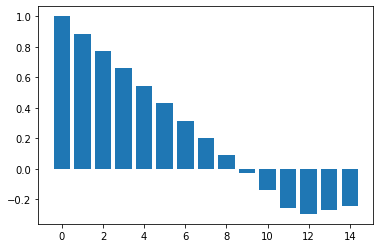

In [91]:
acf_vals = acf(first_diff)
num_lags = 15
plt.bar(range(num_lags), acf_vals[:num_lags])

In [92]:
train_end = datetime(2018,1,1)
test_end = datetime(2021,1,1)

train_data = lim_world_happ[:train_end]
test_data = lim_world_happ[train_end + timedelta(days=1):test_end]

order = (0,1,0)
seasonal_order = (0, 0, 1, 4)

model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
start = time()
model_fit = model.fit()
end = time()
print("Fitting Time:", end - start)
print(model_fit.summary())

Fitting Time: 0.3098409175872803
                                      SARIMAX Results                                      
Dep. Variable:                         Life Ladder   No. Observations:                  144
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 4)   Log Likelihood                 557.708
Date:                             Thu, 02 Dec 2021   AIC                          -1111.417
Time:                                     23:31:11   BIC                          -1105.491
Sample:                                 01-31-2006   HQIC                         -1109.009
                                      - 12-31-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L4        0.5675      0.090      6.293      0.000       0.391       

In [93]:
len(test_data)

36

Text(0, 0.5, 'Error')

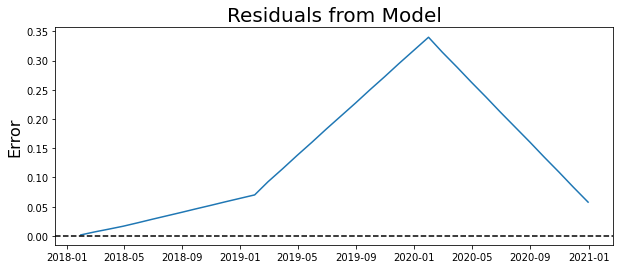

In [94]:
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Mean Absolute Percent Error: 0.0248
Root Mean Squared Error: 0.17549977437758327


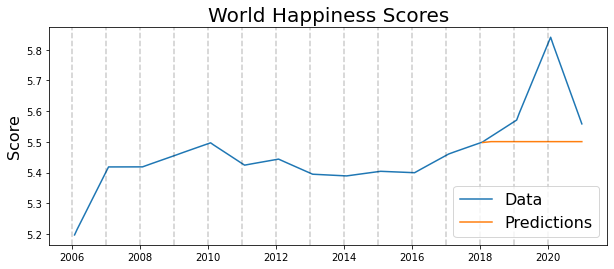

In [95]:
plt.figure(figsize=(10,4))

plt.plot(lim_world_happ)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)
plt.title('World Happiness Scores', fontsize=20)
plt.ylabel('Score', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
    
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))    
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Text(0, 0.5, 'Error')

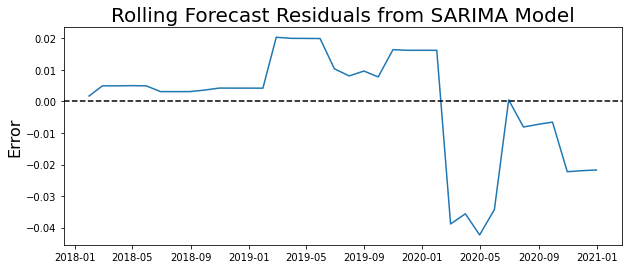

In [96]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_world_happ[:train_end-timedelta(weeks=4)]
    model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    
    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred
rolling_residuals = test_data - rolling_predictions

plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Mean Absolute Percent Error: 0.0023
Root Mean Squared Error: 0.01713470882348027


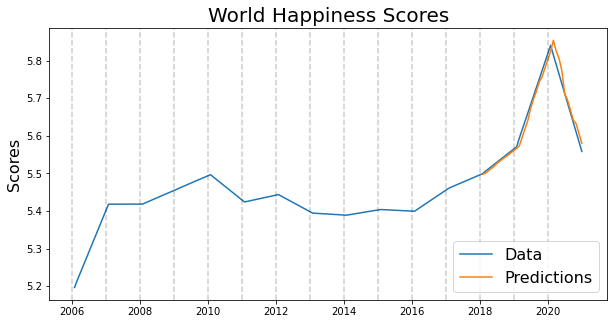

In [97]:
plt.figure(figsize=(10,5))
plt.plot(lim_world_happ)
plt.plot(rolling_predictions)
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.title('World Happiness Scores', fontsize=20)
plt.ylabel('Scores', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
    
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

In [98]:
model_fit.forecast(24)

2020-12-31    5.580202
2021-01-31    5.576272
2021-02-28    5.564707
2021-03-31    5.553141
2021-04-30    5.553141
2021-05-31    5.553141
2021-06-30    5.553141
2021-07-31    5.553141
2021-08-31    5.553141
2021-09-30    5.553141
2021-10-31    5.553141
2021-11-30    5.553141
2021-12-31    5.553141
2022-01-31    5.553141
2022-02-28    5.553141
2022-03-31    5.553141
2022-04-30    5.553141
2022-05-31    5.553141
2022-06-30    5.553141
2022-07-31    5.553141
2022-08-31    5.553141
2022-09-30    5.553141
2022-10-31    5.553141
2022-11-30    5.553141
Freq: M, Name: predicted_mean, dtype: float64

### Evaluation

Our best models came out to a r2 score of .79 and .88 meaning that between our two models 79% and 88% of the variation in suicide rates and happiness scores can be determined by our features. The most significant features in our data were, social support, freedom to make life choices, education, social support, and fixed broadband services. With these features we were able to determine the fluxuation in happiness scores and suicide rates with fairly well accuracy. The World Health Organization can use the model to determine if suicide rates are to increase in a certain country and possibly take action accordanly.

### Conclusions

To conclude we can see that every country is different and suicide and mental health can be very complex but with predictive modeling we can use different features to see if certain country is predicted to have a increase in suicides and act accordanly. Recomendations would include Universal Mental Health care for indeviduals experiancing hardship. More recommendations would vary by country but making it a priority to have accesss electricity and basic water needs should be focuesed on. Last is social safety net programs for those experiancing hardship such as health care programs, employment security programs, and child care assistance. One very big topic our analysis did not touch on is substance abuse and the affect it has on mental health. For future reaserch this would be the first thing to include as it has a great impact on mental health and possibly suicides. The complexity of the subjecct and missing a significat factor in mental health means that our analysis does not fully solve the problem but definitly a step in the right direction. 